<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load the data

In [3]:
house = pd.read_csv('./housing.csv')

# Changing all the column names to lower case

In [4]:
import string
punc = string.punctuation 

house.columns = [col.strip(punc).lower() for col in house.columns]

# Removing all the punctuation and spaces in the mszoning column so we can easily remove all the non residential entries.

In [5]:
house.mszoning = [ ''.join(char.strip(punc).strip(' ') for char in row[1]) for row in house['mszoning'].iteritems()]

In [6]:
house = house[~(house.mszoning == 'Call')]

In [7]:
house.mszoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: mszoning, dtype: int64

In [8]:
house.shape

(1450, 81)

# Remove outliers in the dataset

In [9]:
house.drop([1298,], inplace=True)

In [10]:
house.drop([ 523,], inplace=True)

In [11]:
house.shape

(1448, 81)

# Having a look at the relationship between some of the fixed variabes and the target (Sale Price)
# I have chosen to build the model on just three fixed variables, Year Built, Lot Frontage and Ground Floor Living Area.

In [12]:
house[['saleprice', 'lotfrontage','grlivarea', 'yearbuilt']].corr()

,saleprice,lotfrontage,grlivarea,yearbuilt
saleprice,1.000000,0.374048,0.735293,0.518325
lotfrontage,0.374048,1.000000,0.358513,0.118072
grlivarea,0.735293,0.358513,1.000000,0.192132
yearbuilt,0.518325,0.118072,0.192132,1.000000


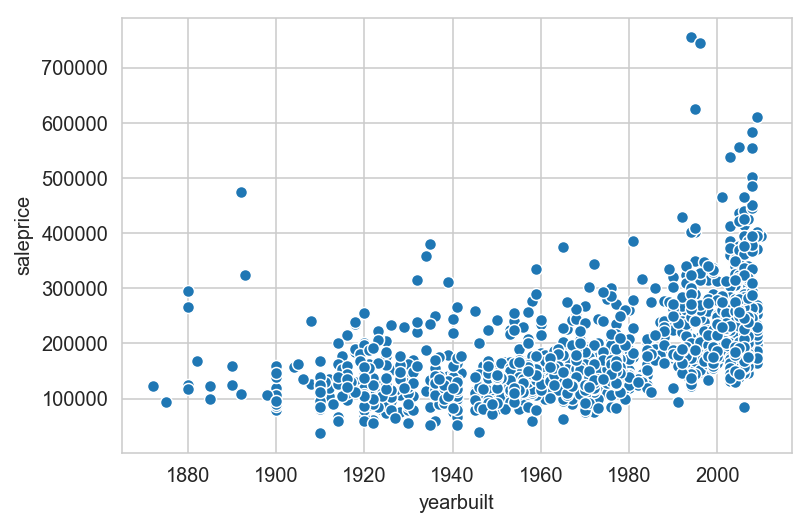

In [13]:
sns.scatterplot(x=house.yearbuilt, y=house.saleprice)

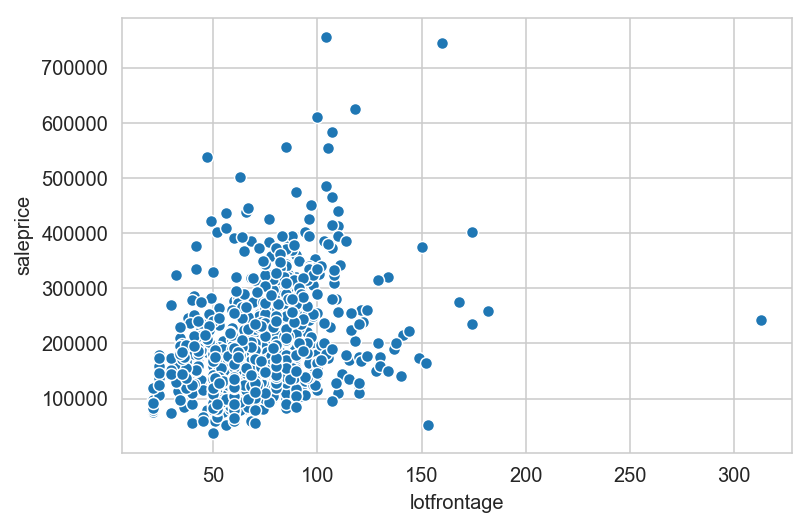

In [14]:
sns.scatterplot(x=house.lotfrontage, y=house.saleprice)

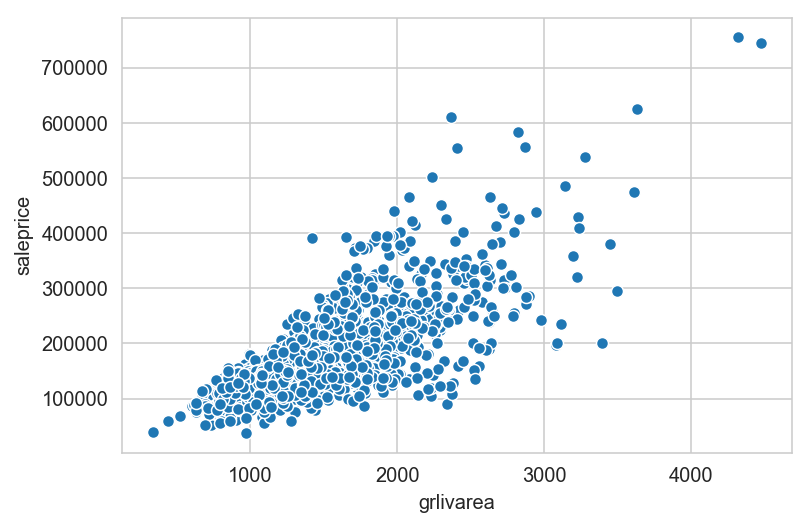

In [15]:
sns.scatterplot(x=house.grlivarea, y=house.saleprice)

# There seems to be a degree of heteroscedasticity in some of the variables which can be seen in the way the points diverge on the scatterplot.
# We can reduce the effect this has by taking the log of the variables.

In [16]:
house['log_saleprice'] = np.log(house.saleprice)
house['log_yearbuilt'] = np.log(house.yearbuilt)
house['log_lotfrontage'] = np.log(house.lotfrontage)
house['log_grlivarea'] = np.log(house.grlivarea)

# the spread of the points now looks a lot more even

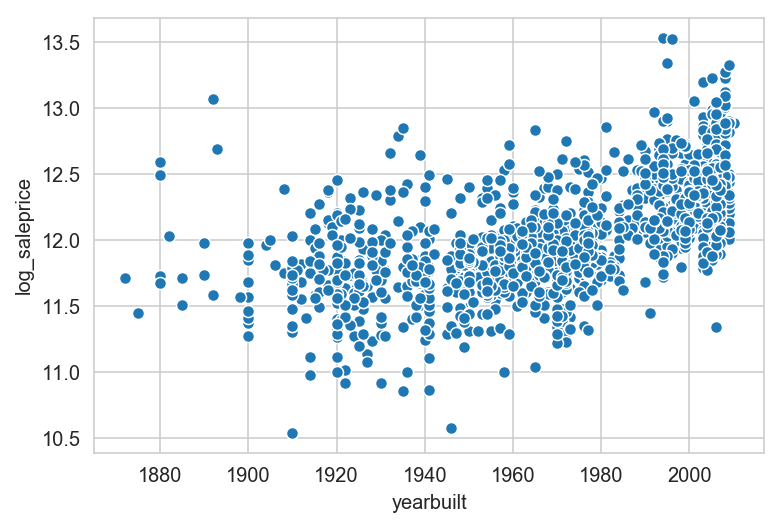

In [17]:
sns.scatterplot(x=house.yearbuilt, y=house.log_saleprice)

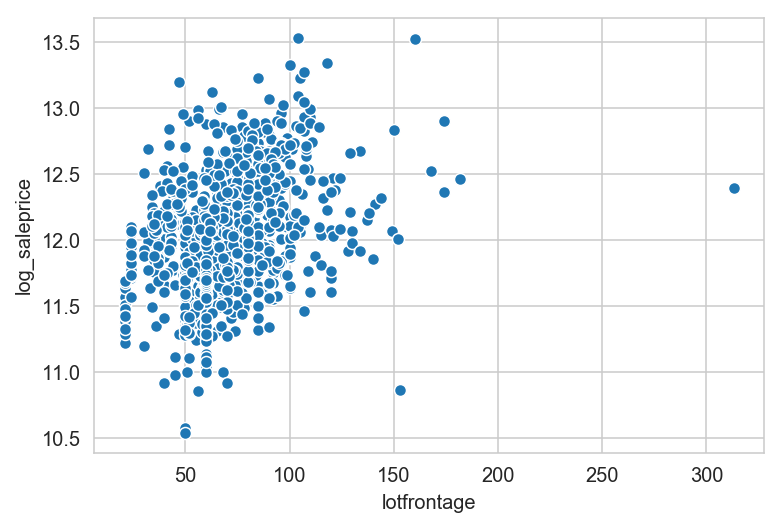

In [18]:
sns.scatterplot(x=house.lotfrontage, y=house.log_saleprice)

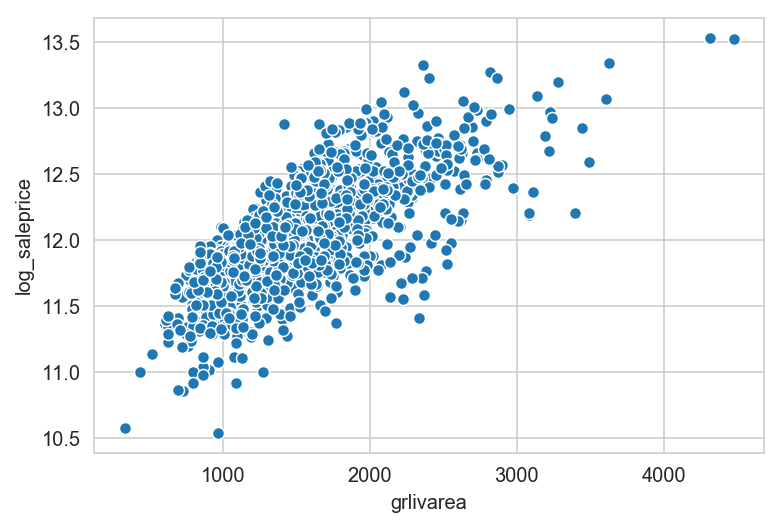

In [19]:
sns.scatterplot(x=house.grlivarea, y=house.log_saleprice)

# Taking the log also helps make the distributions to become more normal

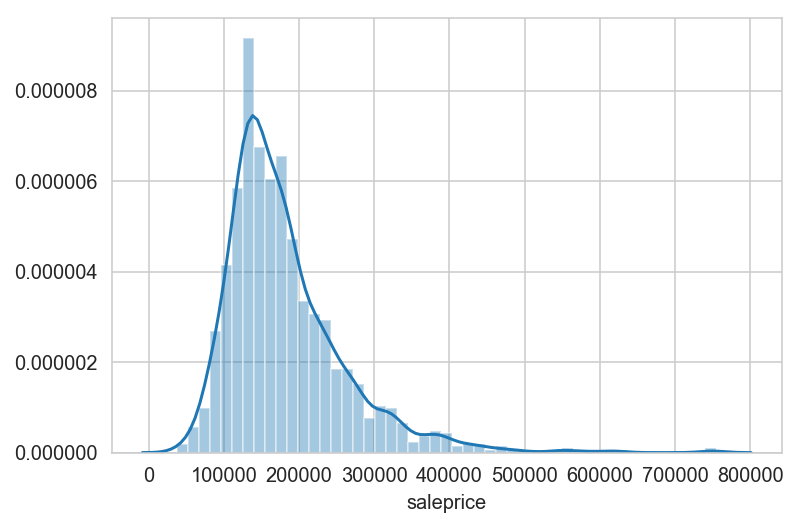

In [20]:
sns_plot = sns.distplot(house.saleprice)
sns_plot.figure.savefig("saleprice.png")

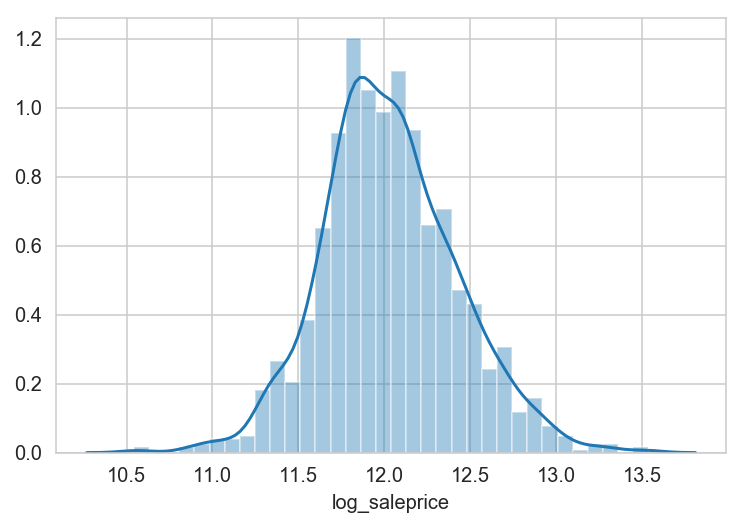

In [21]:
sns_plot2 = sns.distplot(house.log_saleprice)
sns_plot2.figure.savefig("salepricelog.png")

# Setting up two dataframe for the chosen fixed variables, I am making one with the normal variables and one iwth the logs to compare the results. 

In [22]:
fixed_names = ['lotfrontage','grlivarea', 'yearbuilt']

In [23]:
fixed_log_names = ['log_lotfrontage','log_grlivarea', 'log_yearbuilt']

In [24]:
fixed_df = house[fixed_names]

In [25]:
fixed_log_df = house[fixed_log_names]

# replace the null values with the median value for lot frontage

In [26]:
fixed_df.isnull().sum()

lotfrontage    259
grlivarea        0
yearbuilt        0
dtype: int64

In [27]:
fixed_log_df.isnull().sum()

log_lotfrontage    259
log_grlivarea        0
log_yearbuilt        0
dtype: int64

In [28]:
fixed_df.lotfrontage.fillna(fixed_df.lotfrontage.median(), inplace=True)

In [29]:
fixed_log_df.log_lotfrontage.fillna(fixed_log_df.log_lotfrontage.median(), inplace=True)

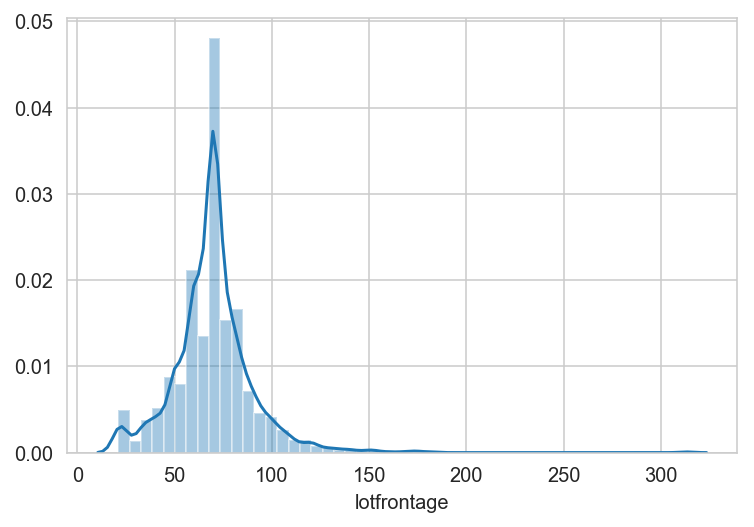

In [30]:
sns.distplot(fixed_df.lotfrontage)

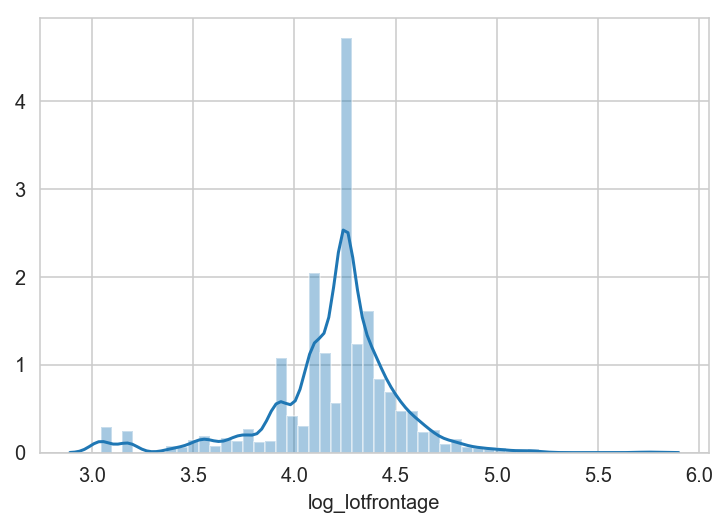

In [31]:
sns.distplot(fixed_log_df.log_lotfrontage)

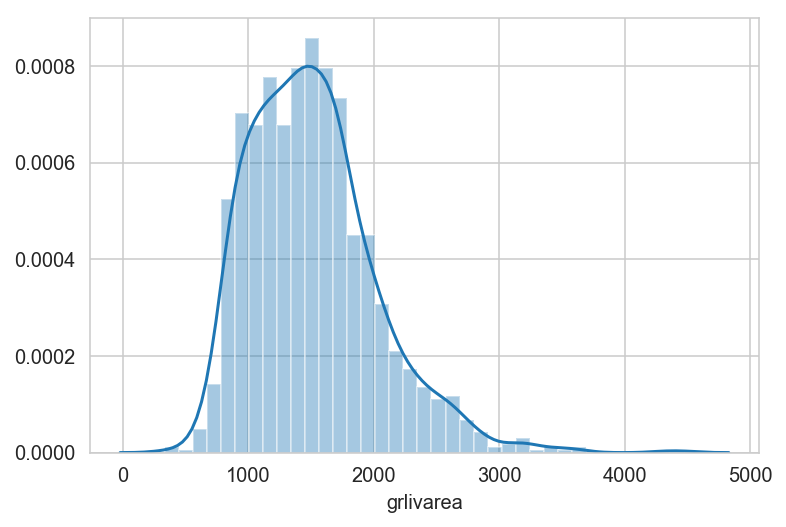

In [32]:
sns.distplot(fixed_df.grlivarea)

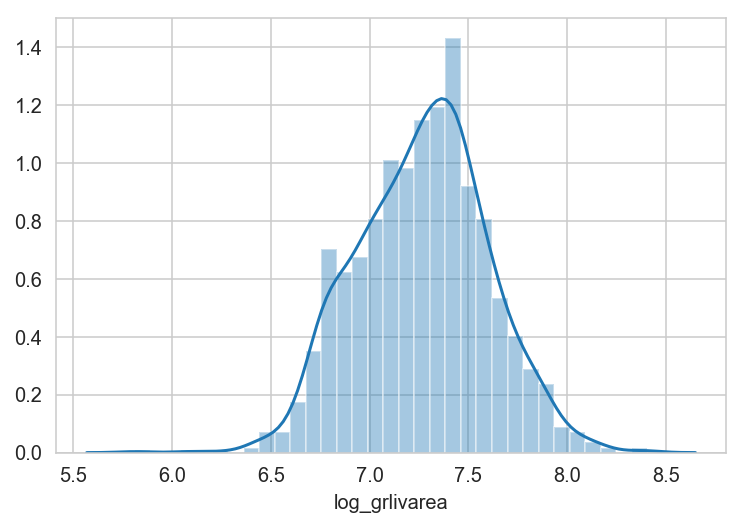

In [33]:
sns.distplot(fixed_log_df.log_grlivarea)

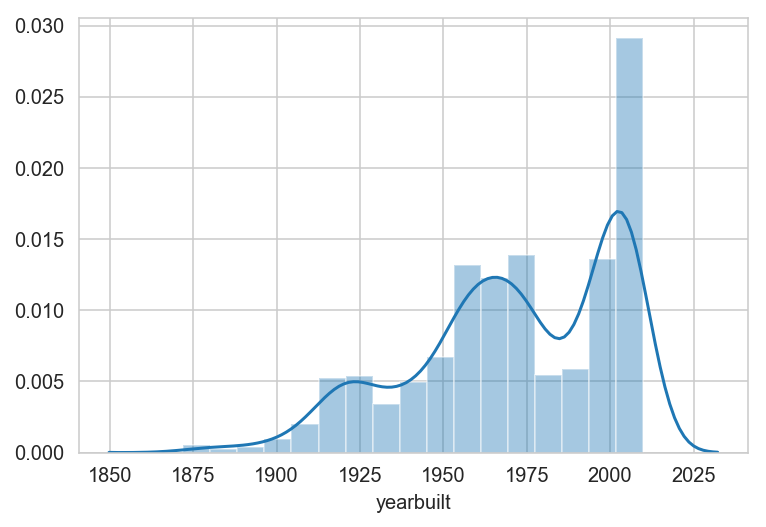

In [34]:
sns.distplot(fixed_df.yearbuilt)

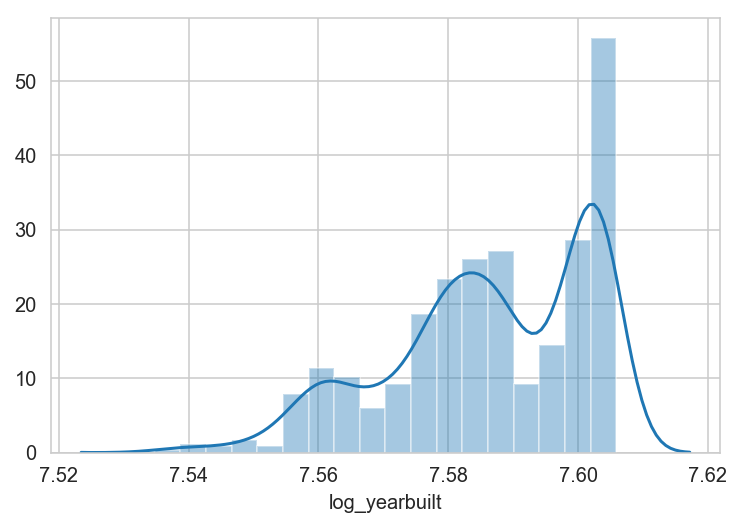

In [35]:
sns.distplot(fixed_log_df.log_yearbuilt)

In [36]:
fixed_df.shape

(1448, 3)

In [37]:
fixed_log_df.shape

(1448, 3)

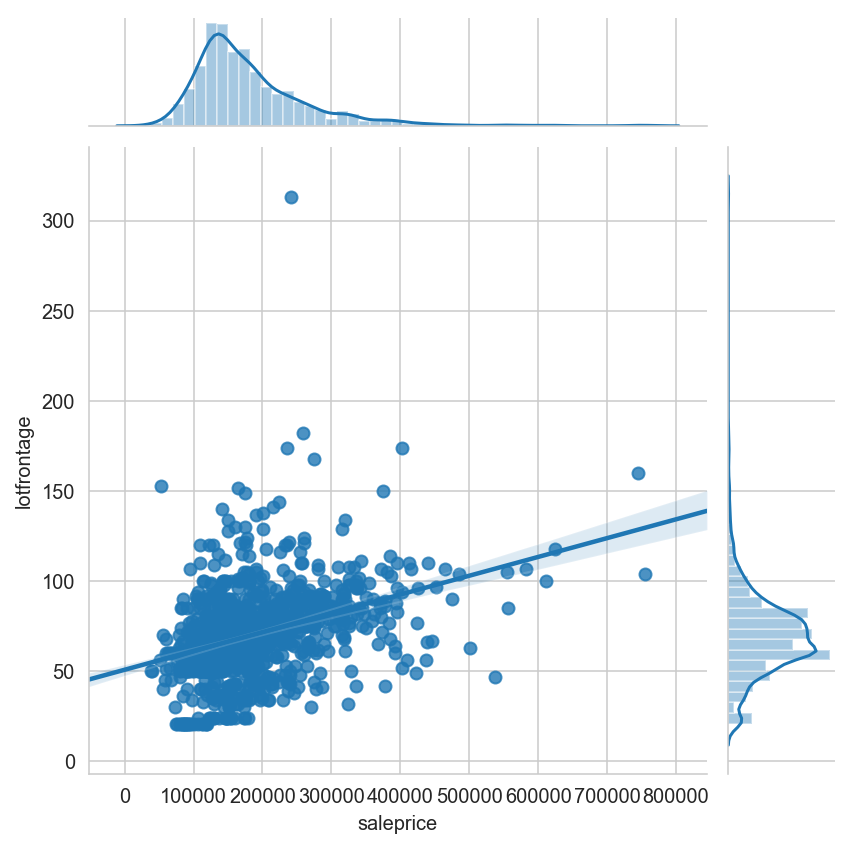

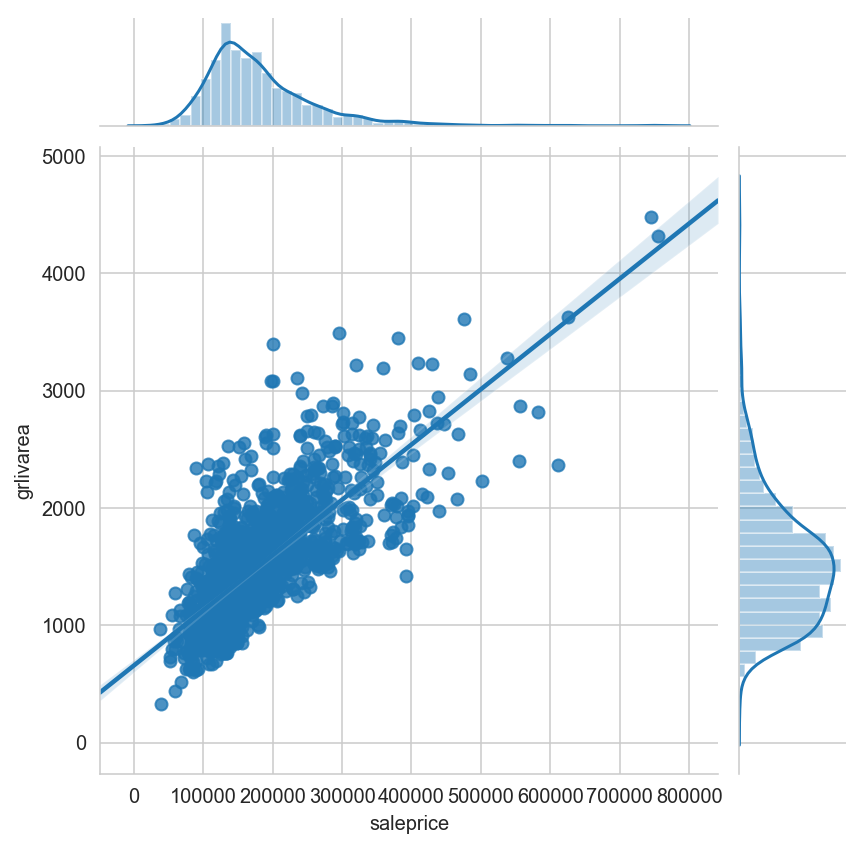

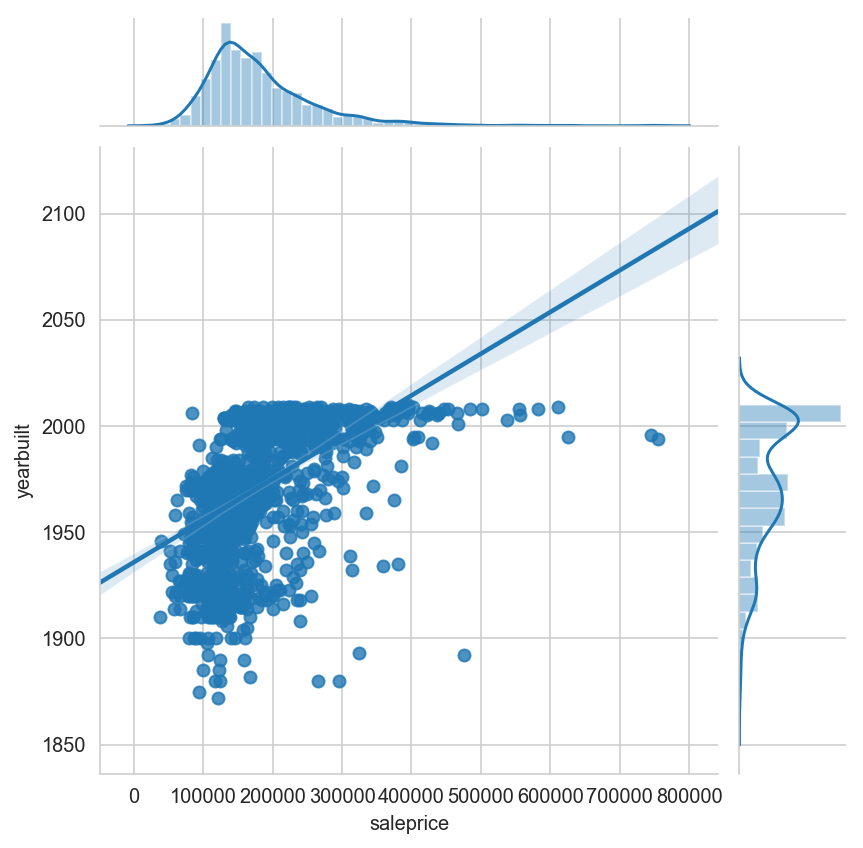

In [38]:
sns.jointplot('saleprice', 'lotfrontage', data=house, kind="reg")
sns.jointplot('saleprice', 'grlivarea', data=house, kind="reg")
sns.jointplot('saleprice', 'yearbuilt', data=house, kind="reg")

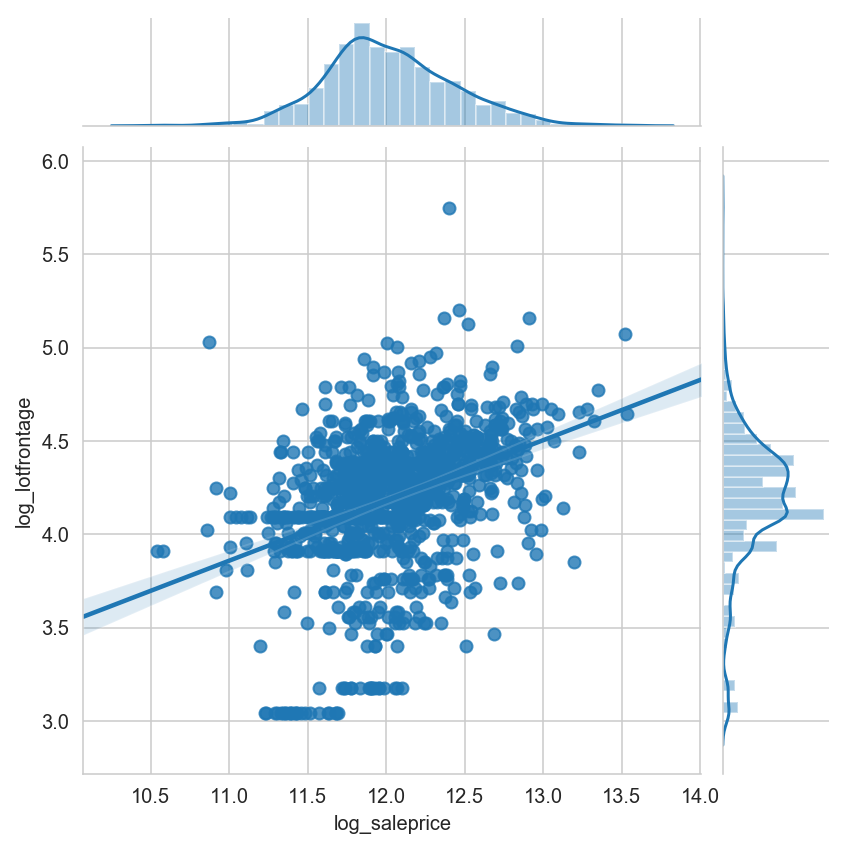

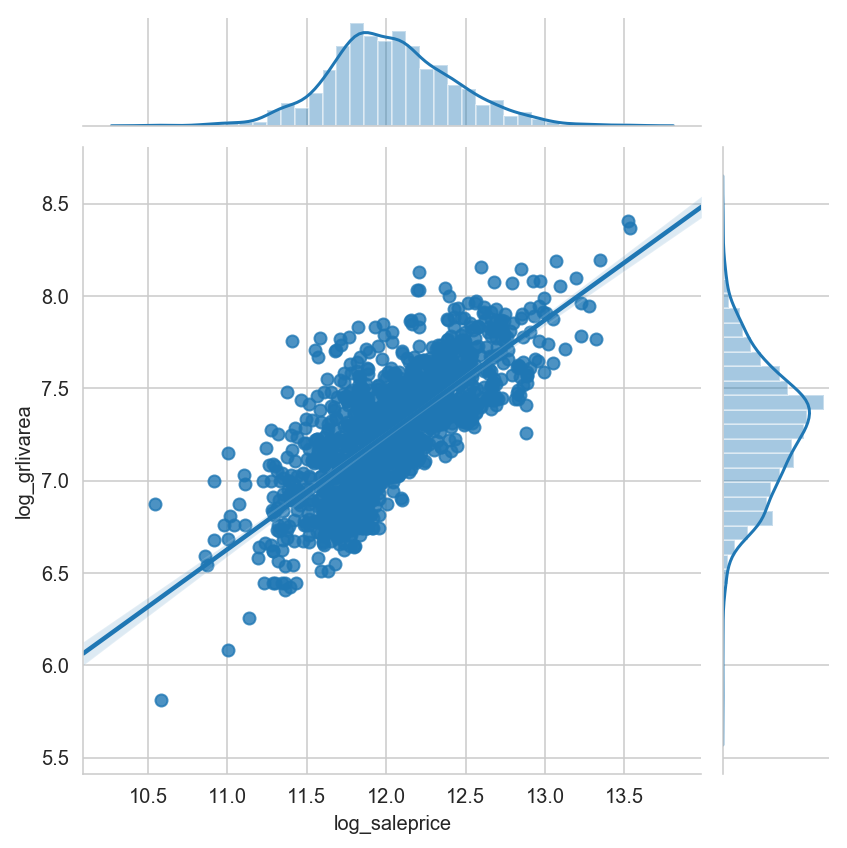

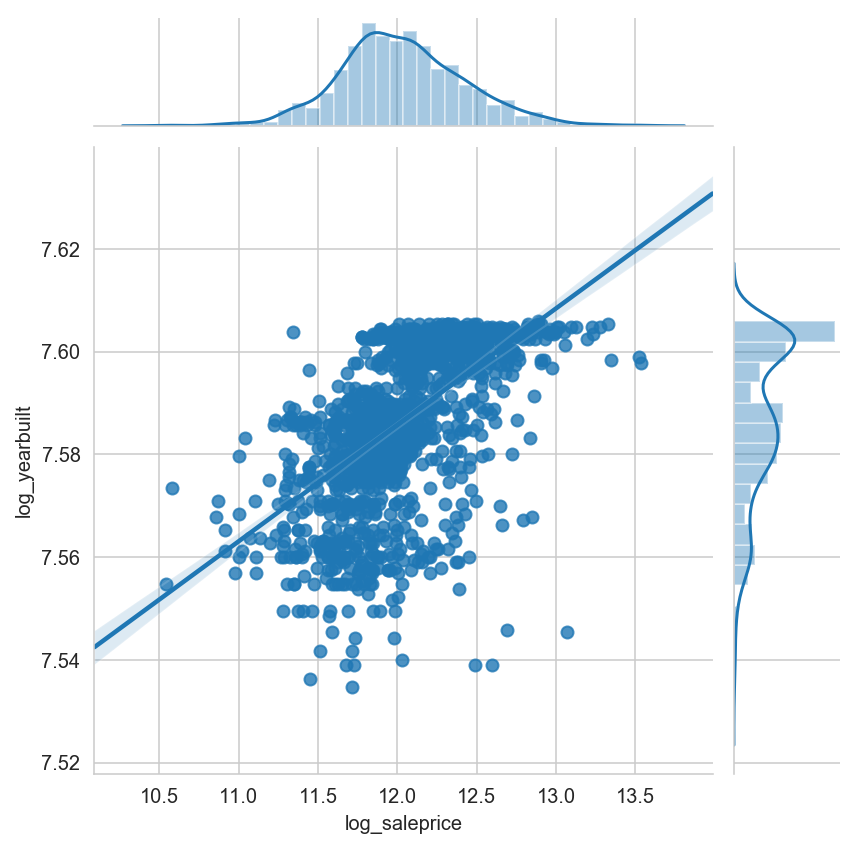

In [39]:
sns.jointplot('log_saleprice', 'log_lotfrontage', data=house, kind="reg")
sns.jointplot('log_saleprice', 'log_grlivarea', data=house, kind="reg")
sns.jointplot('log_saleprice', 'log_yearbuilt', data=house, kind="reg")

# Set up the linear regression for the normal variables with the training set all the houses that were sold before 2010 and the test set all the houses that were sold in 2010

In [40]:
y = house.saleprice

In [41]:
X = fixed_df

In [42]:
X_train = X[house.yrsold != 2010]
X_test = X[house.yrsold == 2010]

y_train = y[house.yrsold != 2010]
y_test = y[house.yrsold == 2010]

In [43]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print('Training score: {}'.format(lr.score(X_train, y_train)))
print('Test score: {}'.format(lr.score(X_test, y_test)))

Training score: 0.7042158887807481
Test score: 0.6587783536996957


# The training and test scores aren't great but considering I randomly chose three variables to base it on, it's actually pretty good.

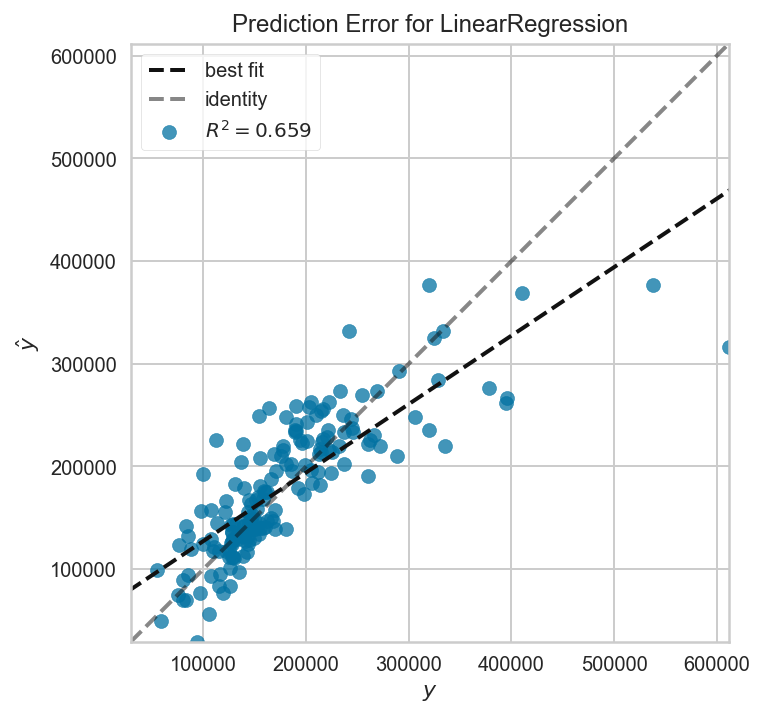

In [44]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof(outpath="error_pred.png")             

# I can now get the predicted values from our model and compare them to the actuals. This gives us our residuals which we can take into the next question. Hopefully we can use the renovatable features to explain our residuals.

In [45]:
predict = pd.DataFrame()
predict['Actual'] = y
predict['Predicted'] = lr.predict(X)
predict['Residual'] = predict.Predicted - predict.Actual

Text(0.5, 1.0, 'Model 1')

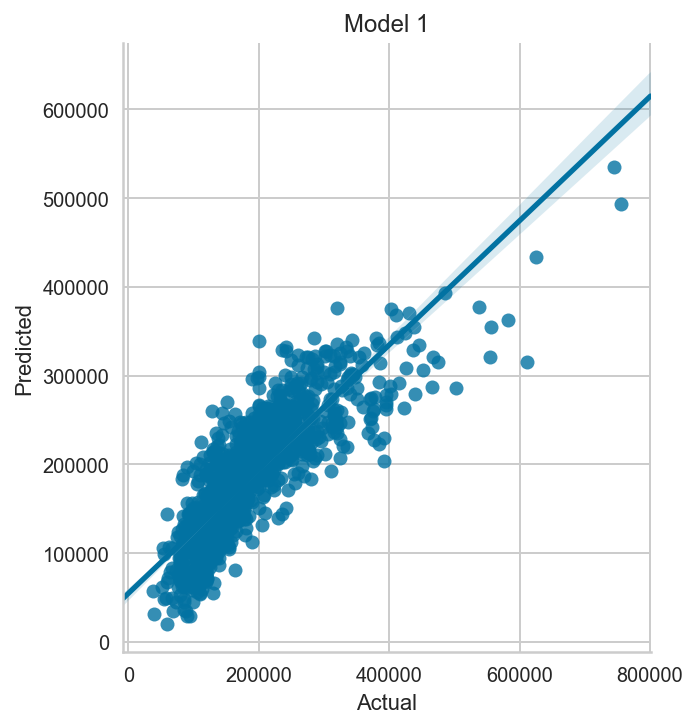

In [46]:
sns.lmplot(x='Actual', y='Predicted', data = predict)
ax = plt.gca()
ax.set_title("Model 1")

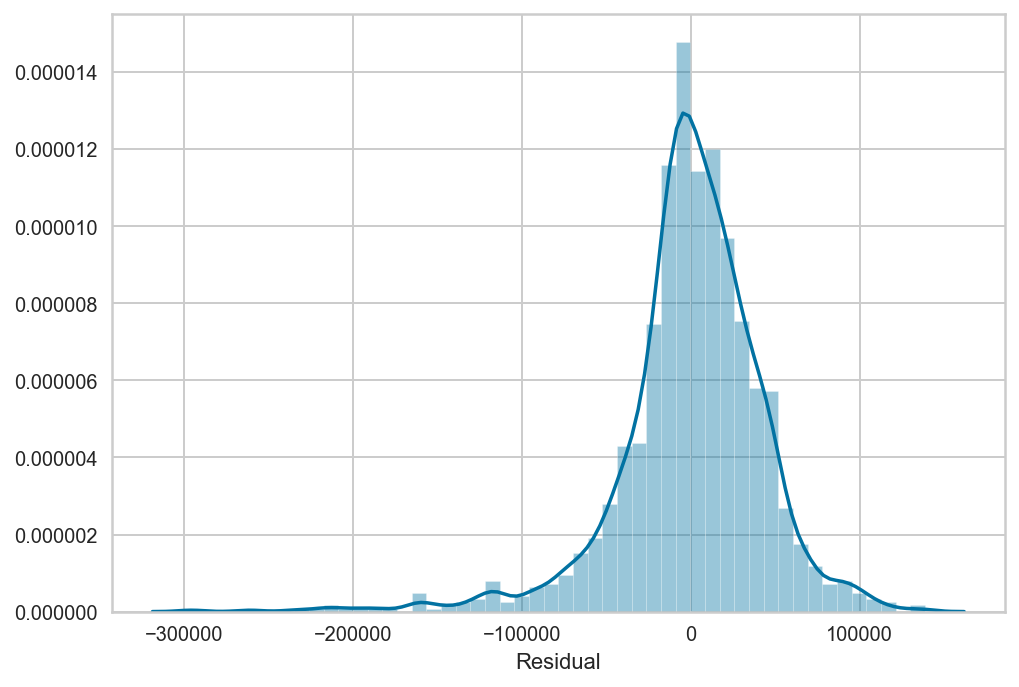

In [47]:
sns_plot3 = sns.distplot(predict.Residual)
sns_plot3.figure.savefig("residuals.png")

# Now I will set up a regression with the log variables and target and see if we have any better luck predicting our target values.

In [48]:
y_log = house.log_saleprice

In [49]:
X_log = fixed_log_df

In [50]:
X_log_train = X_log[house.yrsold != 2010]
X_log_test = X_log[house.yrsold == 2010]

y_log_train = y_log[house.yrsold != 2010]
y_log_test = y_log[house.yrsold == 2010]

In [51]:
lr = LinearRegression()
log_model = lr.fit(X_log_train, y_log_train)
print('Training score: {}'.format(lr.score(X_log_train, y_log_train)))
print('Test score: {}'.format(lr.score(X_log_test, y_log_test)))

Training score: 0.7462767020787986
Test score: 0.7202052424168475


# It scores considerably better than the standard variables, I guess the time spent looking into the properties and distribution was worth it.

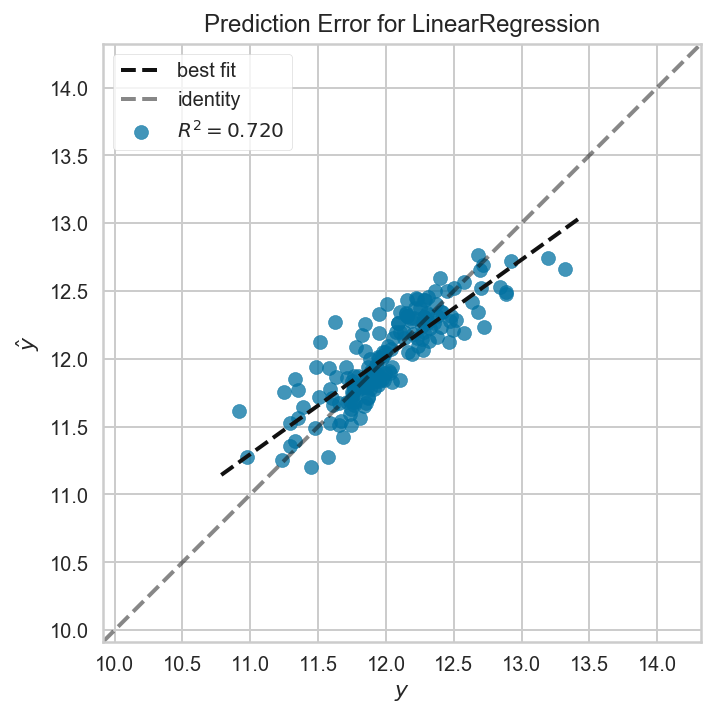

In [52]:
from yellowbrick.regressor import PredictionError

log_visualizer = PredictionError(log_model)

log_visualizer.fit(X_log_train, y_log_train)  # Fit the training data to the visualizer
log_visualizer.score(X_log_test, y_log_test)  # Evaluate the model on the test data
log_g = log_visualizer.poof(outpath="error_pred_log.png")             #

In [53]:
log_predict = pd.DataFrame()
log_predict['Actual'] = y_log
log_predict['Predicted'] = lr.predict(X_log)
log_predict['Residual'] = log_predict.Predicted - log_predict.Actual

Text(0.5, 1.0, 'Model 1 log')

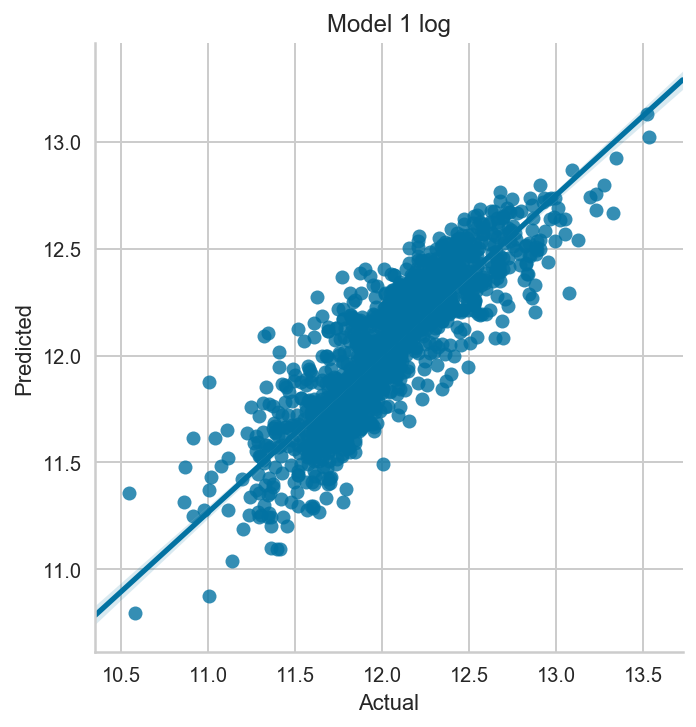

In [54]:
sns.lmplot(x='Actual', y='Predicted', data = log_predict)
ax = plt.gca()
ax.set_title("Model 1 log")

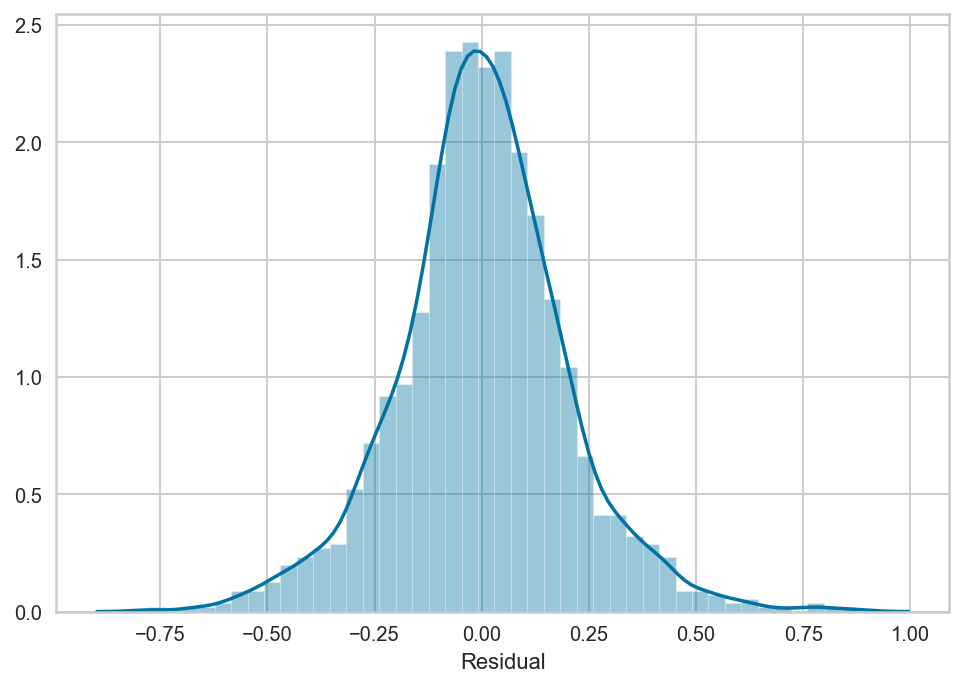

In [55]:
sns_plot4 = sns.distplot(log_predict.Residual)
sns_plot4.figure.savefig("residuals_log.png")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# For this question, i have again just randomly chosen four renovatable variables to see if I can use these to predict the residuals. If I can get a model to predict the residuals at a high accuracy, then it should show that these renovatable variables explain our difference in predicted value and actual value.

In [56]:
reno_names = ['overallqual', 'heatingqc', 'kitchenqual', 'exterqual']

In [57]:
reno_df = house[reno_names]

In [58]:
reno_df.isnull().sum()

overallqual    0
heatingqc      0
kitchenqual    0
exterqual      0
dtype: int64

# Before I can go too far, I need to convert all these new variables into numerical entries.

In [59]:
reno_df.heatingqc.unique()

array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object)

In [60]:
reno_df.kitchenqual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [61]:
reno_df.exterqual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [62]:
reno_df.heatingqc.replace({'Ex': 5, 'Gd': 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}, inplace=True)

In [63]:
reno_df.kitchenqual.replace({'Ex': 5, 'Gd': 4, 'TA' : 3, 'Fa' : 2}, inplace=True);

In [64]:
reno_df.exterqual.replace({'Ex': 5, 'Gd': 4, 'TA' : 3, 'Fa' : 2}, inplace=True);

In [65]:
reno_df.shape

(1448, 4)

# Now we can set up our regression model to see if these variables are able to predict the residuals from question one.

In [66]:
y1 = log_predict.Residual

In [67]:
X1 = reno_df

In [68]:
X1_train = X1[house.yrsold != 2010]
X1_test = X1[house.yrsold == 2010]

y1_train = y1[house.yrsold != 2010]
y1_test = y1[house.yrsold == 2010]

In [69]:
model2 = lr.fit(X1_train, y1_train)
print('Training score: {}'.format(lr.score(X1_train, y1_train)))
print('Training score: {}'.format(lr.score(X1_test, y1_test)))

Training score: 0.15455815915223703
Training score: 0.15801334279898505


# Not unsurprisingly, the model has not fared too well.

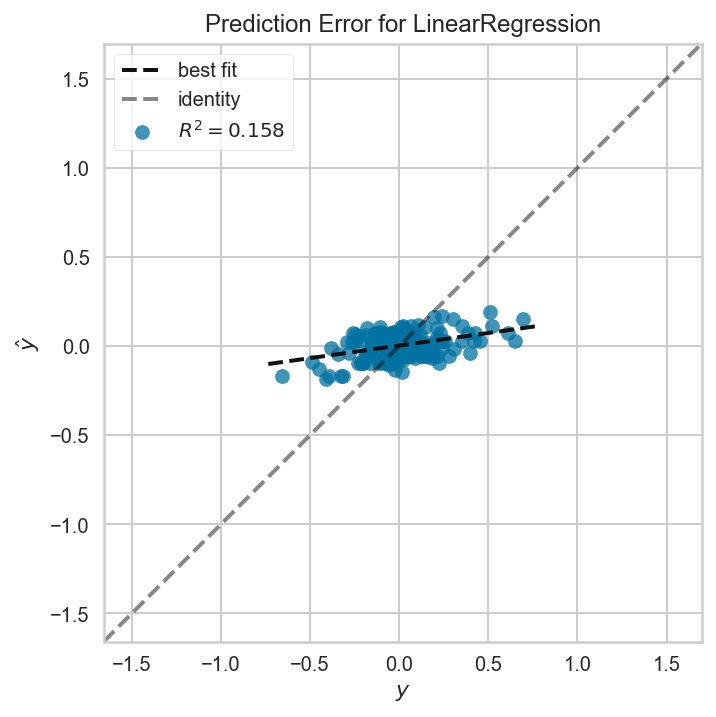

In [70]:
visualizer = PredictionError(model2)

visualizer.fit(X1_train, y1_train)  # Fit the training data to the visualizer
visualizer.score(X1_test, y1_test)  # Evaluate the model on the test data
g = visualizer.poof(outpath="renovatable.png")             # 

In [71]:
pred_res = pd.DataFrame()
pred_res['Actual'] = y1
pred_res['Predicted'] = lr.predict(X1)
pred_res['Residual'] = predict.Predicted - predict.Actual

Text(0.5, 1.0, 'Model 2')

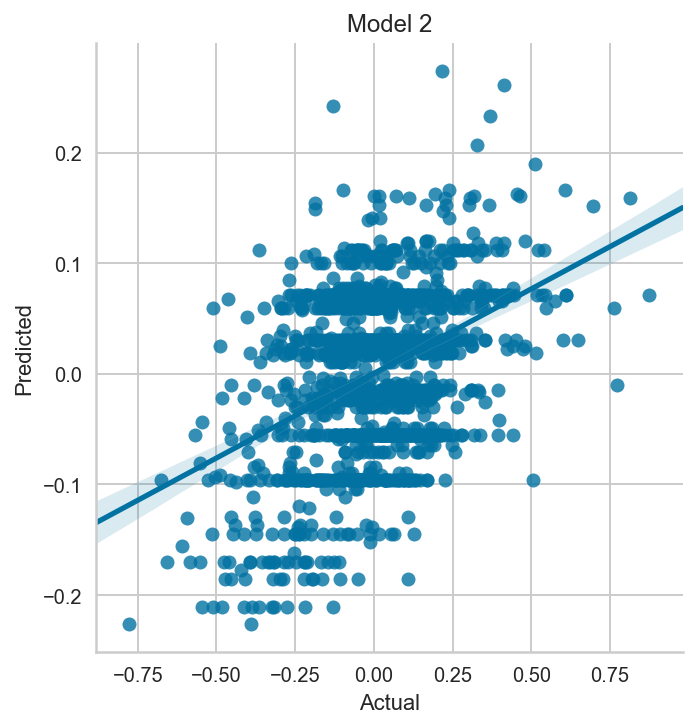

In [72]:
sns.lmplot(x='Actual', y='Predicted', data = pred_res)
ax = plt.gca()
ax.set_title("Model 2")

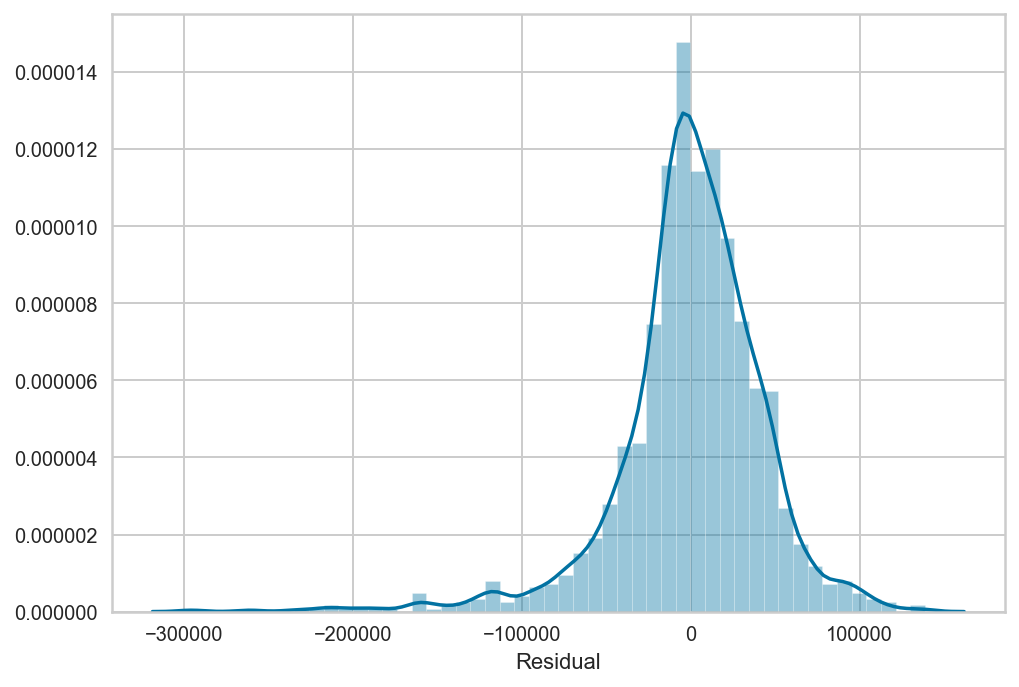

In [73]:
sns.distplot(pred_res.Residual)

# To conclude, I think that by increasing the number of variables in both regressions would have increased our power to predict the sale price. 

# Even with this being the case, I'm not so sure that the renovatable features would be able to predict the residuals at a high enough rate to say that by using a combination of both feature types, we could predict the actual sale price.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: